In [1]:
import time
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

In [2]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami
input_distribution = ishigami.input_distribution
ishigami_true_indices = ishigami.first_order_sobol_indices

Kriging with spherical Cross Validation Q2 score with 1000 observations: 0.4421040062539706
n_sample_gp: 500, max_budget: 100
Absolute error: [ 0.06117205  0.20563742  0.03039171]
MC var: [ 0.00134295  0.00183758  0.0020937 ]
Kriging var: [ 0.03439896  0.02416122  0.00795177]
Sum of vars: [ 0.03574191  0.02599879  0.01004548]
Total var: [ 0.03440342  0.02416718  0.00795852]
Difference ratio vars: [ 0.03890563  0.07578942  0.26222952]
Elapsed time: 16.27 s

n_sample_gp: 500, max_budget: 100
Absolute error: [  5.92161067e-02   2.11857924e-01   1.59575237e-04]
MC var: [ 0.0012751   0.00184596  0.00205348]
Kriging var: [ 0.03330737  0.02115856  0.00773789]
Sum of vars: [ 0.03458247  0.02300451  0.00979137]
Total var: [ 0.03346488  0.02167674  0.00828553]
Difference ratio vars: [ 0.03339605  0.06125342  0.18174315]
Elapsed time: 14.76 s



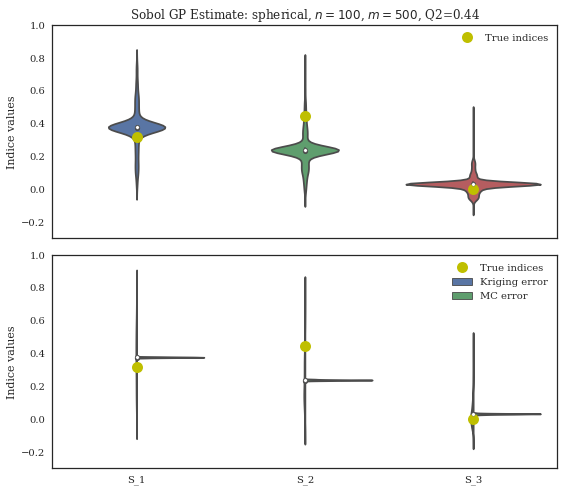

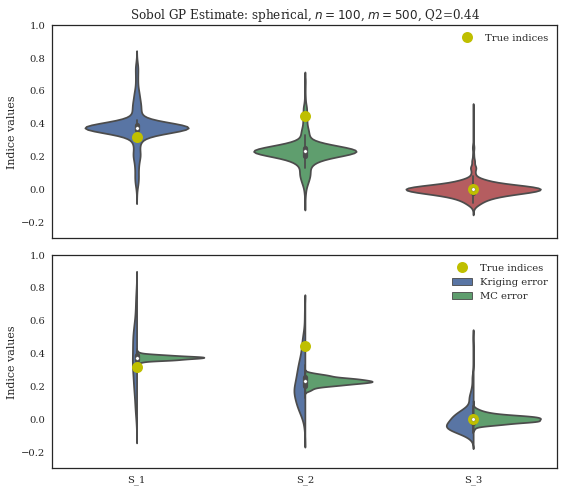

In [10]:
max_budgets = [100]
n_samples = [500]
n_boot = 500
n_realization = 300
basis_type = 'linear'
kernels = ['spherical']

n_sample_cv = 1000
ylim = [-.3, 1.]
with_MC_estimate = False
mean_method = True
savefig = False

sobol = SobolIndices(input_distribution)
sobol_kriging = SobolKrigingIndices(input_distribution)
indiv_bootstraps = [True, False]

all_results = []

for max_budget in max_budgets:
    for kernel in kernels:
        if with_MC_estimate:
            sobol.build_mc_sample(model, int(max_budget/(2*dim)))
            first_indices_mc = sobol.compute_indices(n_boot=n_boot)
            df_first_indices_mc = create_df_from_mc_indices(first_indices_mc)

        meta_model = sobol_kriging.build_meta_model(model, n_sample=max_budget, basis_type=basis_type, kernel=kernel)

        score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
        print('Kriging with {0} Cross Validation Q2 score with {1} observations: {2}'.format(kernel, n_sample_cv, score_q2_cv))
        for indiv_bootstrap in indiv_bootstraps:
            for n_sample in n_samples:
                t_start = time.time()
                print('n_sample_gp: %d, max_budget: %d' % (n_sample, max_budget))

                sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization)
                first_indices_gp = sobol_kriging.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstrap)
                mean_first_indices_gp = first_indices_gp.reshape(dim, -1).mean(axis=1)
                error = abs(mean_first_indices_gp - ishigami_true_indices)
                print('Absolute error:', error)
                var_tot = first_indices_gp.reshape(dim, -1).var(axis=1)
                var_MC = first_indices_gp.var(axis=2).mean(axis=1)
                var_gp = first_indices_gp.var(axis=1).mean(axis=1)
                print('MC var:', var_MC)
                print('Kriging var:', var_gp)
                print('Sum of vars:', var_gp + var_MC)
                print('Total var:', var_tot)
                print('Difference ratio vars:', abs(var_tot - (var_gp + var_MC))/var_tot)

                if with_MC_estimate:
                    df_first_indices_mc = create_df_from_indices(first_indices_mc)
                df_first_indices_gp = create_df_from_gp_indices(first_indices_gp, mean_method=mean_method)

                fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 7))
                ax = axes[0]
                sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, ax=ax)
                ax.set_xlabel('')
                ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
                ax.set_title('Sobol GP Estimate: %s, $n=%d$, $m=%d$, Q2=%.2f' % (kernel, max_budget, n_sample, score_q2_cv))
                ax.legend(loc=0)
                ax.set_ylim(ylim)

                ax = axes[1]
                sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True)
                ax.set_xlabel('')
                ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
                ax.legend(loc=0)
                ax.set_ylim(ylim)

                fig.tight_layout()
                if savefig:
                    fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.pdf' % (max_budget, n_realization, n_sample, n_boot))
                    fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.png' % (max_budget, n_realization, n_sample, n_boot))

                print('Elapsed time: %.2f s\n' % (time.time() - t_start))

                all_results.append(first_indices_gp)

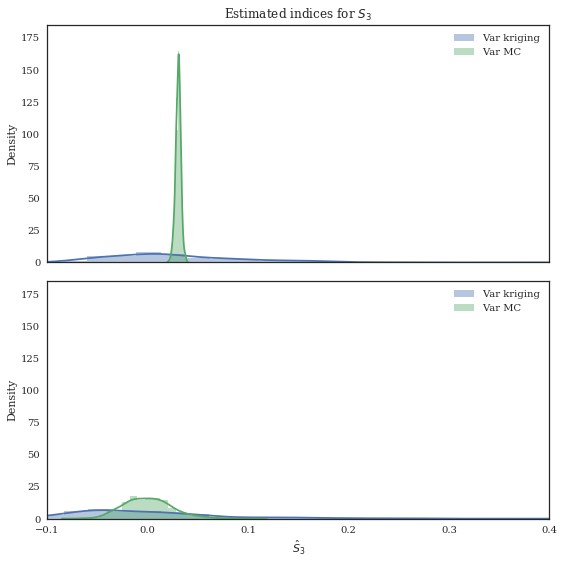

In [11]:
i = 2
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
k = 0
ax = axes[k]
sns.distplot(all_results[k][i, :, :].mean(axis=1), label='Var kriging', norm_hist=True, ax=ax)
sns.distplot(all_results[k][i, :, :].mean(axis=0), label='Var MC', norm_hist=True, ax=ax)
#sns.distplot(all_results[k][i, :, :].reshape(-1, 1), label='Var Total', norm_hist=True, ax=ax)
ax.set_title('Estimated indices for $S_%d$' % (i+1))
ax.legend(loc=0)
ax.axis('tight')
ax.set_xlim([-0.1, 0.4])
ax.set_ylabel('Density')

k = 1
ax = axes[k]
sns.distplot(all_results[k][i, :, :].mean(axis=1), label='Var kriging', norm_hist=True, ax=ax)
sns.distplot(all_results[k][i, :, :].mean(axis=0), label='Var MC', norm_hist=True, ax=ax)
#sns.distplot(all_results[k][i, :, :].reshape(-1, 1), label='Var Total', norm_hist=True, ax=ax)
ax.legend(loc=0)
ax.axis('tight')
ax.set_xlim([-0.1, 0.4])
ax.set_xlabel('$\hat S_%d$' % (i+1))
ax.set_ylabel('Density')

fig.tight_layout()

In [16]:
pd.DataFrame(all_results[0][i, :, :])

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.034286,-0.022766,0.016636,0.109196,0.060186,0.057689,0.112244,0.028625,-0.012708,0.151253,...,-0.003847,0.034440,-0.006607,0.028758,0.010739,0.024710,0.028341,0.129372,0.026023,-0.026873
1,-0.068617,-0.088060,-0.140452,-0.063721,-0.050648,-0.096905,-0.045271,-0.039992,-0.071850,-0.032640,...,-0.036854,0.043708,-0.096043,-0.070339,-0.005481,-0.013951,-0.082276,-0.099802,-0.106810,-0.107458
2,0.005124,-0.047151,0.021896,-0.038184,-0.041313,-0.017171,-0.025733,0.086669,0.033676,0.019294,...,-0.017923,0.051500,-0.031990,0.039371,0.045199,-0.026813,-0.089380,-0.023776,0.035081,0.015993
3,0.020072,0.036228,0.012790,0.030742,0.062752,0.001913,-0.047384,0.076530,0.002848,-0.024536,...,-0.047988,0.001376,0.025749,0.054281,0.091512,0.012850,0.051348,0.012541,0.042325,-0.022457
4,-0.000635,0.014039,0.046440,-0.021202,0.054115,-0.030203,0.068962,-0.023619,-0.043586,0.040225,...,0.053324,-0.043315,-0.015505,-0.051631,-0.015100,-0.030702,0.065938,-0.032592,-0.053718,-0.058403
5,-0.006528,0.029562,-0.062377,0.045452,0.012870,-0.012160,0.056075,-0.099264,-0.120231,-0.032933,...,-0.009750,-0.034828,0.091506,-0.059022,-0.035557,-0.032524,-0.030307,0.076373,-0.015402,-0.027285
6,0.064784,0.029619,0.085818,0.053457,0.127100,0.091193,0.054729,0.080119,0.050490,0.028241,...,0.157487,0.094689,0.083289,0.101340,0.077466,0.143040,0.070796,0.096192,0.006286,0.015943
7,-0.030291,-0.064474,-0.027568,-0.086630,-0.018062,-0.018349,-0.087838,-0.034801,-0.082220,-0.134266,...,-0.011223,-0.033376,-0.020017,-0.059834,-0.112683,0.034836,-0.063515,0.009320,-0.053853,-0.017273
8,0.044982,0.084991,-0.023373,0.018444,0.039818,0.032111,0.043411,0.031888,-0.034470,0.118359,...,0.081922,0.032514,0.070240,-0.017793,0.123641,0.014322,0.038578,0.065766,0.029911,0.110113
9,0.028272,-0.040183,-0.037644,-0.003256,0.013996,0.113312,-0.006621,0.047768,-0.006177,-0.015886,...,0.083736,0.025657,-0.017044,-0.012911,-0.040593,0.060485,0.026226,-0.077881,-0.007465,-0.003422
